In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In order to start, we have to define the equation that defines the projectile motion of the ball. In order to do this I will define the forces that act on the ball seperately to simplify the final equation.

According to NASA (https://www.grc.nasa.gov/WWW/K-12/airplane/balldrag.html) the drag coefficient on a baseball is equal to 0.3
Similarly according to NASA (https://www.grc.nasa.gov/WWW/K-12/airplane/balllift.html) the lift coefficient on a baseball is 0.15

It is also important to note that a baseball's circumfrence and mass are not constant for all baseballs, instead they fall inside a tolerance. The range for radius is .229-.235 meters and the mass is .142-.149 kg (https://en.wikipedia.org/wiki/Baseball_(ball)#:~:targetText=Under%20the%20current%20rules%2C%20a,%E2%80%9376%20mm%20in%20diameter). We will just be using the middle of the range as an approximation; i.e .232 m and .1455 kg

For air density, we will just be using the values provided here (https://www.purplerow.com/2018/1/8/16846116/colorado-rockies-coors-field-arizona-diamondbacks-chase-field-comparison#:~:targetText=On%20a%20typical%20summer%20day,has%20an%20air%20density%20of%20.) This also provides us with an air density for San Diego which we will use as our control.

Average Pitch Height of 1.14 meters

3800 rpm for 35-39, 3175 for 30-34, 2560 for 25-29, 1975 for 20-24, 1425, for 15-19. We can convert this to rps for the magnus force by dividing by 60 giving us: 63.3 rps for 35-39, 52.916 rps for 30-34, 42.6 rps for 25-29, 23.75 rps for 15-19

In [568]:
#Here we will be defining a bunch of constants used later in case we want to change them.
Cd= 0.3
Cl=0.15
mass= .1455
Rball = .232/(2*np.pi)
CrossA= np.pi*(Rball**2)
g=-9.8
Airdensea= 1.182 
Airdenco= .966 
z0=1.14

termvsea=(np.sqrt ( (2 * mass * -g) / (Cd * Airdensea * CrossA) ))
termvco=(np.sqrt ( (2 * mass * -g) / (Cd * Airdenco * CrossA) ))


In [569]:
def terminaldrag(Location): #Arg requires either co or sea for the two heights, This terminal drag is never used as the ball never reaches terminal velocity
    if Location == "co":
        return(.5*Cd*Airdenco*CrossA*termvco**2)
    elif Location == "sea":
        return(.5*Cd*Airdensea*CrossA*termvsea**2)

def drag(vel,Location): #This is a function for drag based on the velocity
    if Location == "co":
        return (.5*Cd*Airdenco*CrossA*(vel**2))
    elif Location == "sea":
        return (.5*Cd*Airdensea*CrossA*(vel**2))
    
def lift(vel,spin,Location): #This calculates lift based on spin in rps and the velocity
    if Location == 'co':
        return(Cl*(4 * np.pi**2 * Rball**3 * spin * Airdenco * vel) * (4/3))
    elif Location == 'sea':
        return(Cl*(4 * np.pi**2 * Rball**3 * spin * Airdensea * vel) * (4/3))


def ascensionf(vel, Location): #This calculates the total opposing force as the ball rises when drag and gravity are both negative
    if Location == 'co':
        return( (mass*g) - drag(vel, Location))
    elif Location =="sea":
        return( (mass*g) - drag(vel, Location))
    

In [570]:
def Baseballflight(t, y, spin, Location): # This will be the equation solved by the runga kutta method. It includes both the affect on the x and y axis
    '''y is an array with [X0,Y0,Vx,Vy]'''
    
    dydt= np.zeros(4)
    
    dydt[1]=y[3]
    if y[3]>=0:
        dydt[3]= (ascensionf(y[3],Location)+lift(y[2],spin,Location))/mass #it is important to note that as the baseball begins to fall, drag will actually start to help it stay in the air, and thus we must hvave two differnt equations
    elif y[3]<0:
        dydt[3]= ((mass*g)+drag(y[3],Location)+lift(y[2],spin,Location))/mass
    dydt[0]=y[2]
    dydt[2]= -drag(y[2],Location)/mass
    return(dydt)

Now I will be including the Runga Kutta method as a way to solve these equations. I will be largely using the code Professor Miller Provided in his example on the Runga Kutta Method. However, I have changed it to work with the function I defined for the flight of the ball. Also I edited to stop if it detected that the ball had hit the ground

In [571]:
def RungeKutta4(func, y_0, t, spin, Location):
    """ Classical Runge-Kutta (RK4) approximation to a first-order ODE system
    with initial conditions.

    Args:
        func: (callable) The first-order ODE system to be approximated.
        y_0:  (array)    The initial condition.
        t:    (array)    A sequence of time points for which to solve for y.
        args: (dict)     Extra arguments to pass to function.

    Out:
        y:    (array)    The approximated solution of the system at each time in t,
                         with the initial value y_0 in the first row.
    """

    # Initialise the approximation array
    y = np.zeros([len(t), len(y_0)])
    y[0] = y_0

    # Loop through the time steps, approximating this step from the prev step
    for i, t_i in enumerate(t[:-1]):
        if y[i][1]<=0:
            return(y)
        else:
            h   = t[i+1] - t_i # size of the step

            k_1 = h*func(t_i, y[i], spin, Location)
            k_2 = h*func(t_i + h/2. , y[i] + k_1/2., spin, Location)
            k_3 = h*func(t_i + h/2. , y[i] + k_2/2., spin, Location)
            k_4 = h*func(t_i + h    , y[i] + k_3, spin, Location)

            y[i+1] = y[i] + 1/6.*(k_1 + 2.*k_2 + 2.*k_3 + k_4) # RK4 step
        
    return y

In [572]:
N     = 250 # Num of steps to take
t_max = 7.5 # Limit of the range to evaluate the function
T    = np.linspace(0., t_max, N+1) # Array of discretized steps

#This is a trial run using the longest home run of the 2019 season
y_0= np.array([0,1.14,48.7*np.cos(27*np.pi/180),48.7*np.sin(27*np.pi/180)])
ysea= RungeKutta4(Baseballflight,y_0,T,42,'sea')
yco=RungeKutta4(Baseballflight,y_0,T,42,'co')

In [573]:
def Cleanerfunc(array): #This function just removes the left over zeroes at the end of the array for cleaner graphs
    temp=array.tolist()
    counter=0
    for k in temp:
        if k[2]==0:
            counter+=1
    for l in range(counter):
        temp.remove([0.0,0.0,0.0,0.0])
    final=np.asarray(temp)       
    return(final)

In [574]:
Seaclean=Cleanerfunc(ysea)

Coclean=Cleanerfunc(yco)

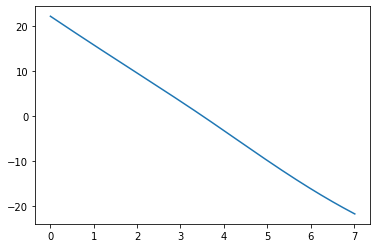

In [575]:
plt.plot(T[:len(Seaclean)],Seaclean[:,3])

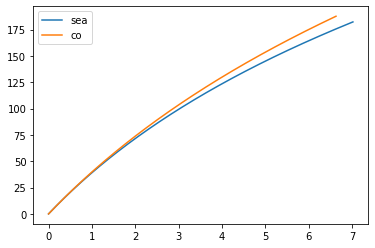

In [576]:
plt.plot(T[:len(Seaclean)],Seaclean[:,0],label='sea')
plt.plot(T[:len(Coclean)],Coclean[:,0],label='co')
plt.legend()

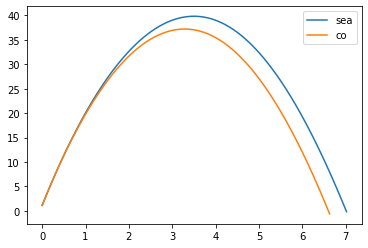

In [577]:
plt.plot(T[:len(Seaclean)],Seaclean[:,1],label='sea')
plt.plot(T[:len(Coclean)],Coclean[:,1],label='co')
plt.legend()

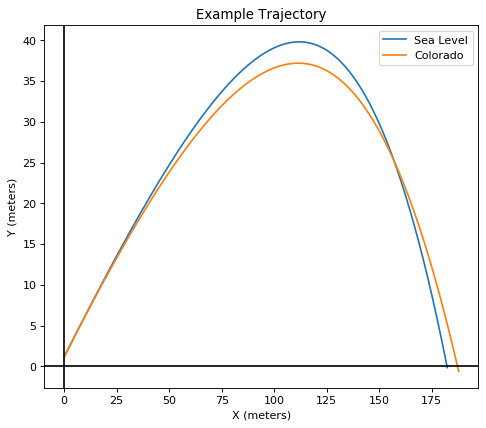

In [578]:
plt.figure(num=None, figsize=(7,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Seaclean[:,0],Seaclean[:,1],label='Sea Level')
plt.plot(Coclean[:,0],Coclean[:,1],label='Colorado')


plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title("Example Trajectory")

plt.axhline(color="black")
plt.axvline(color="black")

plt.legend()
plt.savefig('Example Trajectory')

In [579]:
def vacuumbaseball(t,y,spin,location):
        
    dydt= np.zeros(4)
    
    dydt[1]=y[3]
    dydt[3]= g
    dydt[0]=y[2]
    dydt[2]= 0
    return(dydt)
    

In [580]:
Vacuum=RungeKutta4(vacuumbaseball,y_0,T,1,'Sea')
Vacuumclean=Cleanerfunc(Vacuum)
print(Seaclean[-1][0],Coclean[-1][0],Vacuumclean[-1][0])

182.3241841286394 187.71922477067346 199.16936137139845


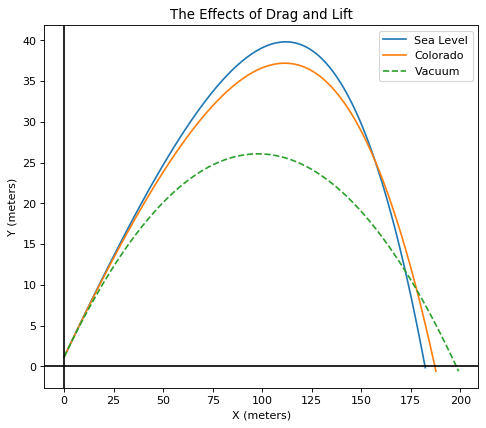

In [581]:
plt.figure(num=None, figsize=(7,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Seaclean[:,0],Seaclean[:,1],label='Sea Level')
plt.plot(Coclean[:,0],Coclean[:,1],label='Colorado')
plt.plot(Vacuumclean[:,0],Vacuumclean[:,1],label="Vacuum",linestyle='--')

plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('The Effects of Drag and Lift')

plt.axhline(color="black")
plt.axvline(color="black")

plt.legend()
plt.savefig('Simulation vs Vacuum')

Now we want to test a set of data to see how many more home runs come out of the set than do before. I'll be using hitting data from 3 players, Kris Bryant, Ji-man Choi and Mookie Bets. Using Statcast to find the exit velocity and launch angle for all of their fly balls from last season. I will calculate how far they would have went using my algorithm for sea level and for colorado and see how many of them get converted

In [596]:
mbactualdist,mbspeedmph, mbangledeg, mbspinrpm = np.loadtxt('Betsdata.csv', unpack=True, skiprows=1,delimiter=',', usecols=(0,1,2,3))
kbactualdist,kbspeedmph, kbangledeg, kbspinrpm = np.loadtxt('Bryantdata.csv', unpack=True, skiprows=1,delimiter=',', usecols=(0,1,2,3))
jcactualdist,jcspeedmph, jcangledeg, jcspinrpm = np.loadtxt('Jimandata.csv', unpack=True, skiprows=1,delimiter=',', usecols=(0,1,2,3))

mbspin=(mbspinrpm/60)
kbspin=(kbspinrpm/60)
jcspin=(jcspinrpm/60)

mbsspeed=(mbspeedmph/2.23694)
kbspeed=(kbspeedmph/2.23694)
jcspeed=(jcspeedmph/2.23694)

mbangle=(mbangledeg/2.23694)
kbangle=(kbangledeg/2.23694)
jcangle=(jcangledeg*)

[46.13445153 45.82152405 45.24037301 41.57465109 44.5251102  42.78165709
 46.22385938 45.73211619 48.19083212 40.85938827 38.44537627 46.00033975
 43.98866308 41.88757857 46.26856331 42.15580212 45.19566908 41.79817072
 42.60284138 38.3112645  40.27823723 47.65438501 41.35113146 41.48524323
 41.79817072 38.93711946 36.70192316 37.86422524 43.22869634 46.84971434
 46.58149079 38.98182338 40.36764509 42.1110982  39.47356657 36.79133101
 43.72043953 45.24037301 41.44053931 46.62619471 36.92544279 43.80984738
 39.6970862  46.04504368 42.42402568 46.80501042 33.12560909 34.95847005
 43.76514345 38.35596842 37.99833701 44.25688664 44.65922197 44.25688664
 46.44737901 38.4900802  41.57465109 41.52994716 43.3181042  37.99833701
 44.07807094 35.49491716 38.4900802  45.59800442 48.19083212 40.45705294
 37.50659383 41.0829079  47.69908893 45.37448479 37.55129775 40.45705294
 45.15096516 47.96731249 39.38415872 37.90892916 43.63103168 41.84287464
 30.53278139]
